# When to use, how to use, demo of ARIMA vs ARIMAX for the same dataset


In [131]:
#importing neccessary libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

from pylab import rcParams

rcParams['figure.figsize'] = 10, 6

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error

import math

In [132]:
# reading csv file

df = pd.read_excel("datasets/taiwan_arimax_dataset.xlsx")

In [133]:
#Print sample few rows
df.head()

,Period,"Population (Mid-Year,Persons)","GDP (Million U.S.$,at Current Prices)",Net enrollment rate
0,1976,16401413,18988,67.57
1,1977,16730895,22252,67.88
2,1978,17042272,27373,67.82
3,1979,17372779,33875,68.19
4,1980,17704538,42292,68.73


**we selected GDP, population and enrollment in Taiwan as the target case. The GDP and population series
data were selected from National Statistics, Taiwan website. The enrollment data sets were
derived from Ministry of Education Taiwan website. All the data sets are covering 44 periods (from
1976 to 2018).**

**We Have Period ie. years , population Data, GDP Data and Net Enrollment Rate.**

In [134]:
df.shape

(45, 4)

### Deviding The Data to Train and Test

In [135]:
train, test = df[0:38], df[38:45]  # splitting the Data into Train test

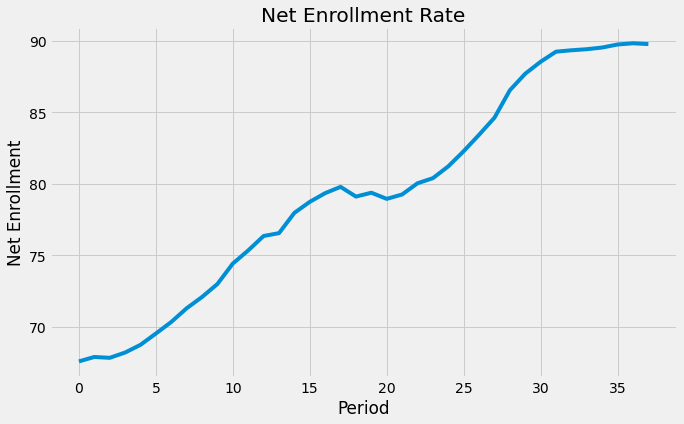

In [136]:
# our target variable is "Net Enrollemnt Rate"

df2 = train  #making a copy of train dataset

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Period')
plt.ylabel('Net Enrollment')

plt.plot(df2['Net enrollment rate'])
plt.title('Net Enrollment Rate')

plt.show()

***Stationarity check is important in time series as we need to check what mathematical operations on the series make it predictable for future. For stationary time series the mean and variance is constant, so it is more predictable compared to non stationary time series. One of the test for stationarity is Augmented Dickey Fuller Test (ADF for short).***



In [137]:
#Test for stationarity

# Testing our Hypothesis

# H0: it is non Stationary
# H1: it is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [138]:
# for target variable Net Enrollment

adfuller_test(train["Net enrollment rate"])

ADF Test Statistic : -0.4570339435900089
p-value : 0.9001318555670108
#Lags Used : 8
Number of Observations Used : 29
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


**Check for seasonal decomposition**

<Figure size 720x432 with 0 Axes>

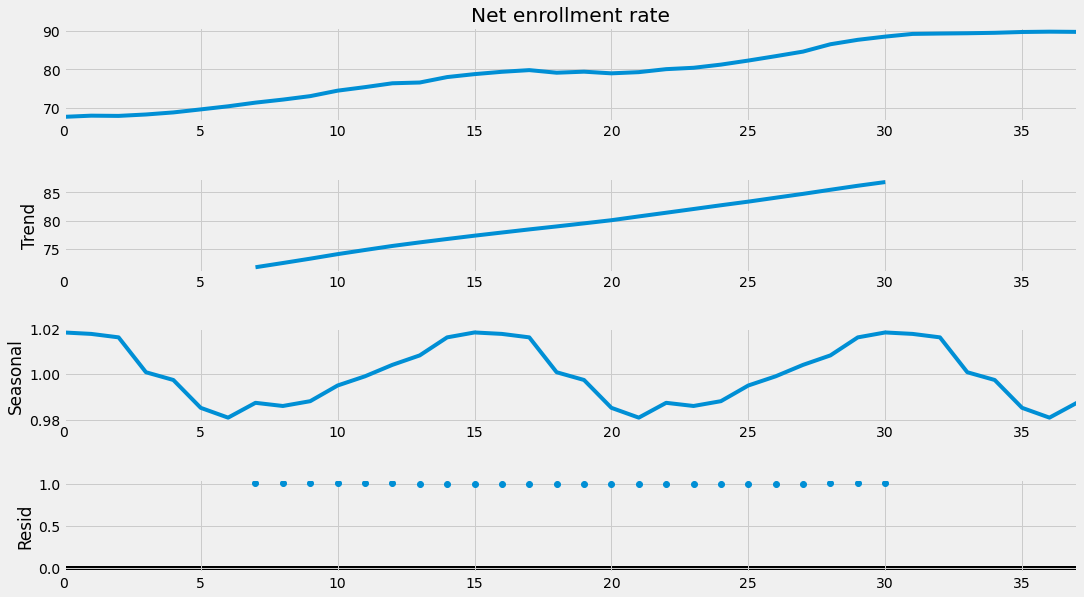

In [139]:
result = seasonal_decompose(df2["Net enrollment rate"], model='multiplicative', freq = 15)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

**Based on multiplicative Model we see that the time series has a strong Trend and the seasionality component is also present, Residual is flat so, most of the variance is explained by trend.**

# Fitting an ARIMA Model

<AxesSubplot:>

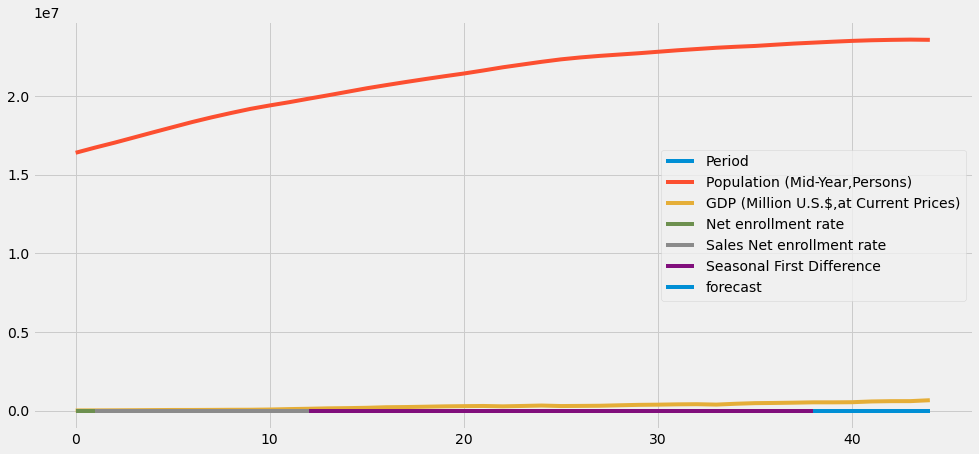

In [156]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
df.plot()

In [157]:
from statsmodels.tsa.stattools import adfuller

In [158]:
test_result=adfuller(df["Net enrollment rate"])

In [159]:
def adfuller_test(Net_enrollment_rate):
    result=adfuller(Net_enrollment_rate)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df[['Net enrollment rate']])

ADF Test Statistic : -1.5788348577515179
p-value : 0.49421612086890065
#Lags Used : 4
Number of Observations : 40
weak evidence against null hypothesis,indicating it is non-stationary 


In [160]:
df['Sales Net enrollment rate'] = df["Net enrollment rate"] - df["Net enrollment rate"].shift(1)
df['Seasonal First Difference']=df["Net enrollment rate"]-df["Net enrollment rate"].shift(12)
df.head()

,Period,"Population (Mid-Year,Persons)","GDP (Million U.S.$,at Current Prices)",Net enrollment rate,Sales Net enrollment rate,Seasonal First Difference,forecast
0,1976,16401413,18988,67.57,NaN,NaN,NaN
1,1977,16730895,22252,67.88,0.31,NaN,NaN
2,1978,17042272,27373,67.82,-0.06,NaN,NaN
3,1979,17372779,33875,68.19,0.37,NaN,NaN
4,1980,17704538,42292,68.73,0.54,NaN,NaN


In [161]:
# Again testing if data is stationary
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -4.205272058756641
p-value : 0.0006454905922227405
#Lags Used : 3
Number of Observations : 29
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<AxesSubplot:>

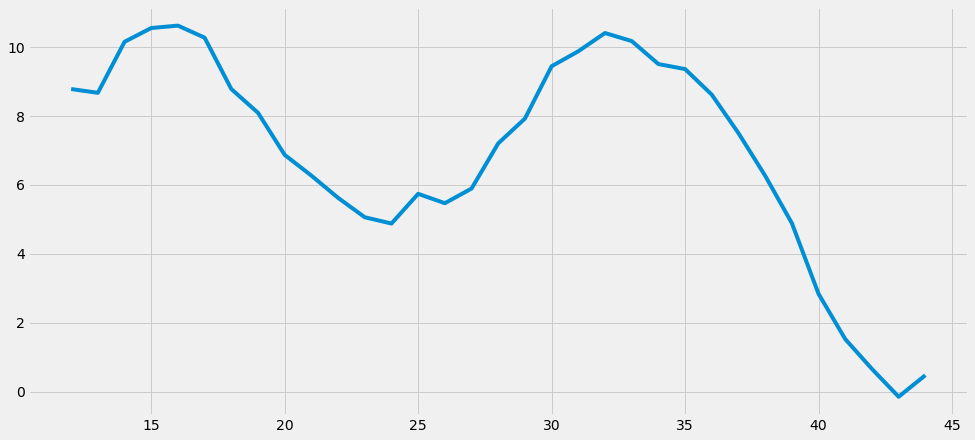

In [162]:
df['Seasonal First Difference'].plot()

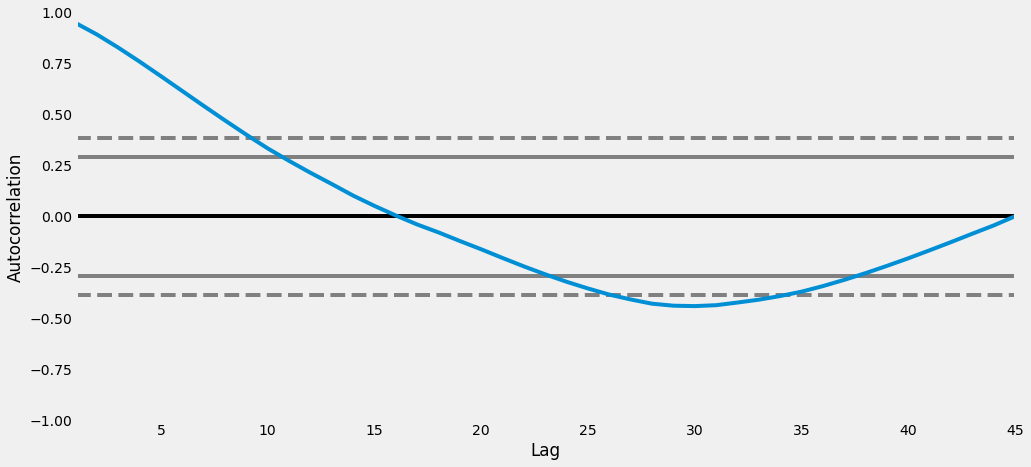

In [163]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df["Net enrollment rate"])
plt.show()

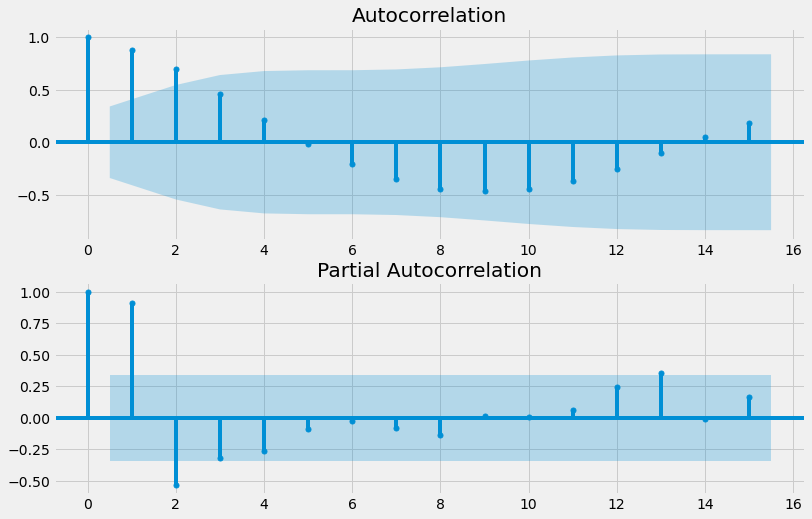

In [164]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].dropna(),lags=15,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].dropna(),lags=15,ax=ax2)

In [165]:
# For non-seasonal data
#p=1, d=1, q=0 or 1

from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(df["Net enrollment rate"],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARIMA Model Results                               
=================================================================================
Dep. Variable:     D.Net enrollment rate   No. Observations:                   44
Model:                    ARIMA(1, 1, 1)   Log Likelihood                 -24.105
Method:                          css-mle   S.D. of innovations              0.416
Date:                   Thu, 17 Feb 2022   AIC                             56.210
Time:                           11:08:40   BIC                             63.347
Sample:                                1   HQIC                            58.857
                                                                                 
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.4901      0.193      2.538      0.011       0.112       0.869
ar.L1.D.Net enrollment rate     0.7751      0.117      6.622      0.000       0.546       1.004
ma.L1.D.Net enrollment rate    -0.2630      0.155     -1.693      0.090      -0.568       0.042
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2902           +0.0000j            1.2902            0.0000
MA.1            3.8016           +0.0000j            3.8016            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:>

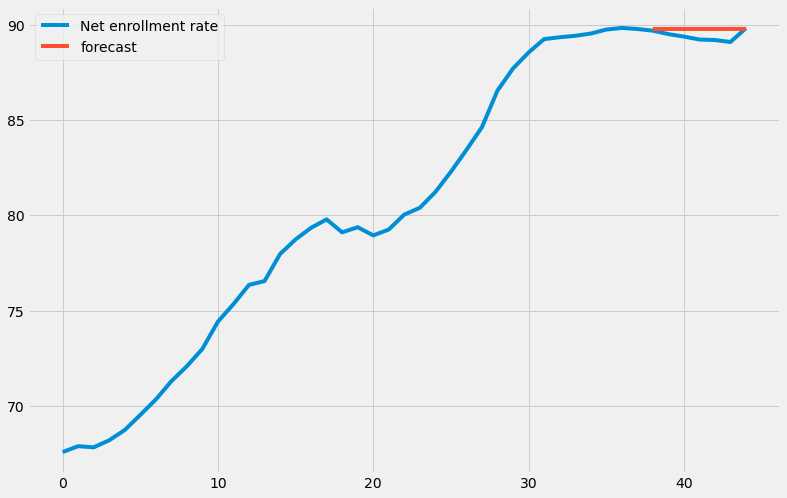

In [166]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df["Net enrollment rate"],order=(1, 1, 1))
results=model.fit()
df['forecast']=results.predict(start=38,end=44,dynamic=True)
df[["Net enrollment rate",'forecast']].plot(figsize=(12,8))

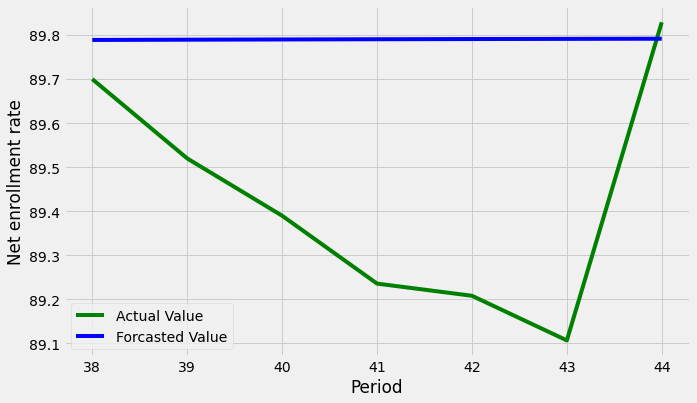

In [167]:
train_data = df.loc[38:,"Net enrollment rate"]

test_data = results.predict(start=38,end=44,dynamic=True)

plt.figure(figsize=(10,6))
plt.grid(True)

plt.xlabel('Period')

plt.ylabel('Net enrollment rate')

plt.plot(train_data, 'green', label='Actual Value'),

plt.plot(test_data, 'blue', label='Forcasted Value')
,
plt.legend()

### Checking For Cross Correlation

**In an autocorrelation model, it is the cross correlation
of a time series while investigating the persistence between lagged times of the same time
series or signal. While the CCF is the degree of similarity between two times series in
different times or space which the lag can be considered when time is under investigation.**

In [168]:
import statsmodels.api as sm

In [169]:
#calculate cross correlation
sm.tsa.stattools.ccf(train["Population (Mid-Year,Persons)"], train["GDP (Million U.S.$,at Current Prices)"], adjusted=False)
# the outputs are read (lag0,lag1,....so, on until lagK)

array([ 0.95910088,  0.85772492,  0.75954482,  0.6630696 ,  0.57525051,
        0.49961014,  0.41916694,  0.34148836,  0.26891225,  0.19962973,
        0.13685761,  0.08069421,  0.02702402, -0.02403504, -0.08116045,
       -0.13120402, -0.17442497, -0.22141074, -0.26474878, -0.30384218,
       -0.33656666, -0.36323805, -0.38535064, -0.39728003, -0.40259013,
       -0.40266363, -0.39493762, -0.38096087, -0.35983803, -0.33431668,
       -0.30702615, -0.27677422, -0.2440093 , -0.20986749, -0.17294966,
       -0.13317792, -0.09111021, -0.04657546])

In [170]:
#calculate cross correlation
sm.tsa.stattools.ccf(train["Net enrollment rate"], train["GDP (Million U.S.$,at Current Prices)"], adjusted=False)
# the outputs are read (lag0,lag1,....so, on until lagK)

array([ 0.970122  ,  0.88297718,  0.79546475,  0.70602257,  0.62445217,
        0.55466708,  0.47875376,  0.40552462,  0.33814591,  0.27354265,
        0.21550069,  0.16679355,  0.11959948,  0.07361579,  0.01570045,
       -0.03304958, -0.07663413, -0.12687889, -0.17586684, -0.22811234,
       -0.27569909, -0.32227391, -0.36586231, -0.39784243, -0.42423259,
       -0.44424554, -0.45332168, -0.4520224 , -0.4386016 , -0.41205369,
       -0.37914158, -0.34036044, -0.29691736, -0.25291229, -0.20687818,
       -0.15817105, -0.10676422, -0.05364764])

**as we can see in both the cases with increase in number of lags the correlation value is Decreasing so, we can say that most recent Data points are Highly correlated**

**---------------------------------------------------------------------------------------------------------------------------------**

In [175]:
# reading csv file

df = pd.read_excel("datasets/taiwan_arimax_dataset.xlsx")

In [176]:
df.head()

,Period,"Population (Mid-Year,Persons)","GDP (Million U.S.$,at Current Prices)",Net enrollment rate
0,1976,16401413,18988,67.57
1,1977,16730895,22252,67.88
2,1978,17042272,27373,67.82
3,1979,17372779,33875,68.19
4,1980,17704538,42292,68.73


In [177]:
train, test = df[0:38], df[38:45]  # splitting the Data into Train test

In [178]:
df2 = train  #making a copy of train dataset

# Running Auto ARIMA with exogenous variables(ARIMAX)

Autoarima is useful as it selects the best values of p,d,q for time series stationarity through an iterative process. Below is brief explaination of p,d,q values
1. p -> is the number of autoregressive terms
2. d -> is the number of nonseasonal differences
3. q -> is the number of lagged forecast errors

In [179]:
df3 = df2[["Population (Mid-Year,Persons)","GDP (Million U.S.$,at Current Prices)"]]
model_autoARIMA = auto_arima(df2["Net enrollment rate"], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=1,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      exogenous= df3)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=165.150, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=93.223, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=170.590, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=264.396, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=64.414, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=61.735, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=64.122, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=64.126, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=59.732, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=61.833, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=62.119, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=62.121, Time=0.07 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 0.753 seconds
                               SARIMAX Results                                
Dep. Variable:                

The Best model is ARIMA(3,0,0) which means we are descibing Net Enrollemnt Rate variable (Y) by using 3rd Order Auto-Regressive Model

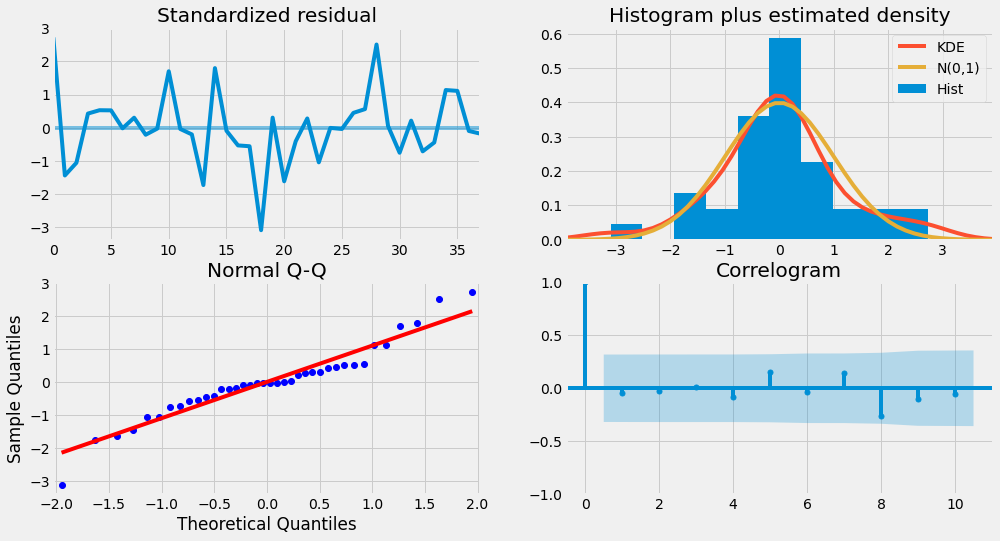

In [180]:
# we'll plot the daignostic metric to check for model accuracy

model_autoARIMA.plot_diagnostics(figsize=(15,8))

plt.show()

In [64]:
# Residual does not show any specific trend
# Histogram is near normal

### Fitting the Best Arimax Model

In [181]:
model= SARIMAX(df2["Net enrollment rate"], 
 exog=df3,               #exogenous variable 
 order=(3,0,0),          #seting the order that yielded best results
 enforce_invertibility=False, enforce_stationarity=False)

### Using the model to Forecast on the test Data.

In [182]:
test

,Period,"Population (Mid-Year,Persons)","GDP (Million U.S.$,at Current Prices)",Net enrollment rate
38,2014,23403635,535332,89.700000
39,2015,23462914,534474,89.520000
40,2016,23515945,543002,89.390000
41,2017,23555522,590780,89.235932
42,2018,23580080,609251,89.208313
43,2019,23596027,611336,89.107047
44,2020,23582179,669324,89.828981


In [183]:
test2 = test  # making a copy of test dataset

In [184]:
#setting up the exogenious variables for test data
test3 = test2[["Population (Mid-Year,Persons)","GDP (Million U.S.$,at Current Prices)"]]

results= model.fit()   # fitting the model

# forcasting using test data and storing the outputs
forecast_1= results.forecast(steps=len(test2["Net enrollment rate"]), exog=test3)

In [185]:
print(forecast_1)

38    89.603420
39    89.479333
40    89.308441
41    88.979357
42    88.746734
43    88.598513
44    88.199164
Name: predicted_mean, dtype: float64


### Plotting the Forcasted Values

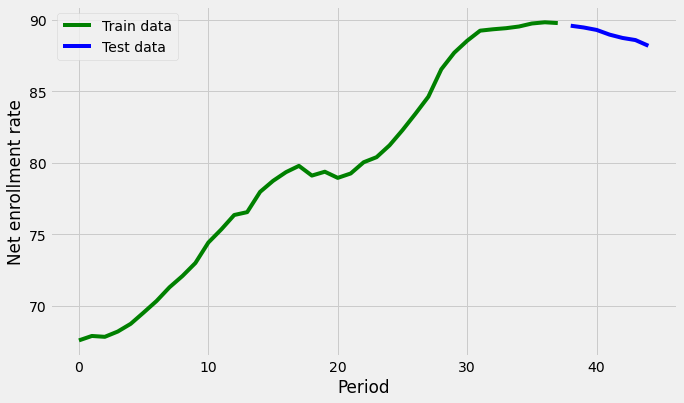

In [186]:
train_data = train["Net enrollment rate"]  # complete train dataset

test_data = forecast_1                     #forcasted values from the test data set

plt.figure(figsize=(10,6))
plt.grid(True)

plt.xlabel('Period')

plt.ylabel('Net enrollment rate')

plt.plot(train_data, 'green', label='Train data')

plt.plot(test_data, 'blue', label='Test data')

plt.legend()

### Comparing Actual Values with Forcasted Values

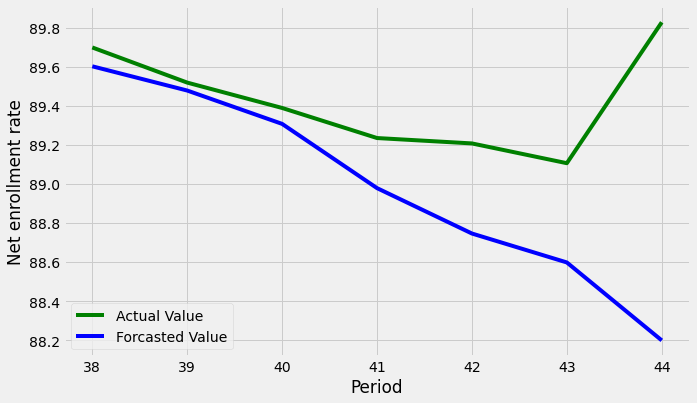

In [187]:
train_data = df.loc[38:,"Net enrollment rate"]

test_data = forecast_1

plt.figure(figsize=(10,6))
plt.grid(True)

plt.xlabel('Period')

plt.ylabel('Net enrollment rate')

plt.plot(train_data, 'green', label='Actual Value'),

plt.plot(test_data, 'blue', label='Forcasted Value')
,
plt.legend()